In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

import IPython.display as ipd
import librosa
import librosa.display

In [2]:
%ls ..

baseline.py                      figs/               requirements.txt
dataset/                         k_morita/           setup.sh
ex9_baseline_adam.py             pytorch_lightning/  test.csv
ex9_baseline_adam_whitenoise.py  README.md           training.csv


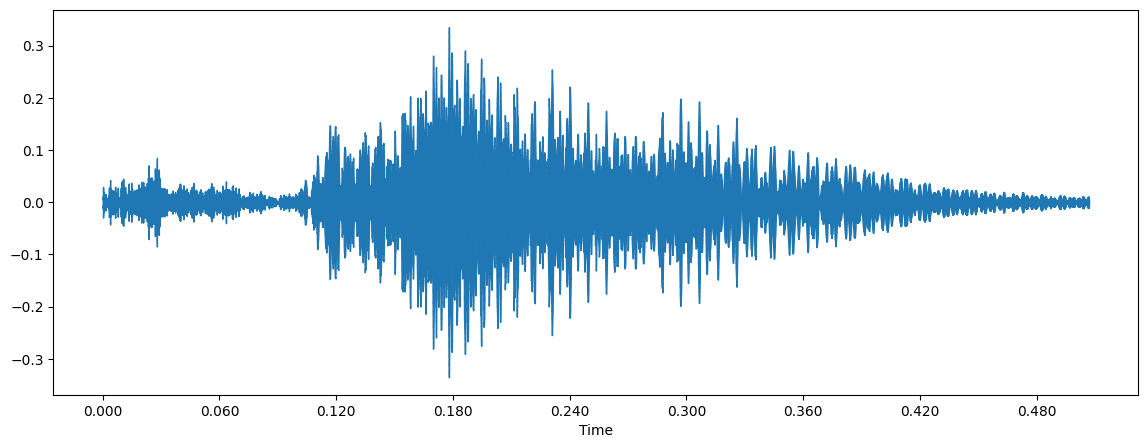

In [3]:
train = pd.read_csv("../training.csv")

import os

tmp = train["path"].values[0]
tmp = os.path.join(os.path.pardir, tmp)

plt.figure(figsize=(14, 5))
data, sample_rate = librosa.load(tmp)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(tmp)

In [9]:
sample_rate

22050

In [4]:
def wav_to_spectrogram(
        audio_path, 
        save_path, 
        spectrogram_dimensions=(64, 64), 
        noverlap=16, 
        cmap="gray_r"
    ):
    sample_rate, samples = wav.read(audio_path)
    fig = plt.figure()
    fig.set_size_inches((
        spectrogram_dimensions[0]/fig.get_dpi(), 
        spectrogram_dimensions[1]/fig.get_dpi()
        ))
    ax = plt.Axes(fig, [0., 0., 1., 1.,])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

def files_to_spectrogram(
        files, 
        save_dir, 
        spectrogram_dimensions=(64, 64), 
        noverlap=12, 
        cmap="gray_r"
    ):
    for file_name in files:
        audio_path = os.path.join(os.path.pardir, file_name)
        spectrogram_path = os.path.join(save_dir, os.path.basename(file_name).replace(".wav", ".png"))
        wav_to_spectrogram(
            audio_path, 
            spectrogram_path, 
            spectrogram_dimensions=spectrogram_dimensions, 
            noverlap=noverlap, 
            cmap=cmap
        )

In [16]:
files = pd.read_csv("../training.csv")
files = files["path"].values
files_to_spectrogram(files, save_dir="spectrograms")

/tmp/ipykernel_3204/926609674.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


In [2]:
%ls spectrograms | wc -l

2700


In [4]:
%ls ../dataset/train/ | wc -l

2700


In [5]:
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array


import pandas as pd
import numpy as np

import os

2023-06-30 15:57:15.088316: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 15:57:15.097099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 15:57:15.245438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 15:57:15.247038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 15:57:16.333431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
from sklearn.model_selection import train_test_split

imageDir = "spectrograms"
train_csv = pd.read_csv("../training.csv")

train_files = train_csv["path"].apply(lambda path: os.path.join("spectrograms", os.path.basename(path).replace(".wav", ".png"))).values
labels = train_csv["label"].values

train_files[:5]

array(['spectrograms/jackson_0.png', 'spectrograms/jackson_1.png',
       'spectrograms/jackson_2.png', 'spectrograms/jackson_3.png',
       'spectrograms/jackson_4.png'], dtype=object)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_files, labels, test_size=0.3)

X_train = [img_to_array(load_img(f)) for f in X_train]
X_test = [img_to_array(load_img(f)) for f in X_test]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [8]:

X_train = np.asanyarray(X_train)
X_test = np.asanyarray(X_test)

X_train /= 255
X_test /= 255

In [9]:
data_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [10]:
data_shape

(64, 64, 3)

In [11]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import models
import tensorflow as tf
import test

In [12]:
def my_MLP_1():
    input_shape = data_shape
    output_dim = 10

    model = Sequential(name="model_1")

    model.add(Conv2D(48, kernel_size=(2,2), activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(2,2), activation="relu"))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(2,2), activation="relu"))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(output_dim, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="Adadelta", metrics=["accuracy"])

    return model





In [13]:
model = my_MLP_1()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 48)        624       
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 48)       192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        12352     
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 128)       32896     
                                                                 
 batch_normalization_2 (Batc  (None, 61, 61, 128)      512 

In [14]:
import pandas as pd
import os

train_csv = pd.read_csv("../training.csv")
train_csv["path"] = train_csv["path"].apply(
    lambda path: os.path.join(
        "spectrograms",
        os.path.basename(path).replace(".wav", ".png")
    ))

train_csv.to_csv("train.csv", index=False)